# Exoplanet Transit Classification (Kepler Mission)
## Exploratory Data Analysis: Part II

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [39]:
sns.set_context("notebook")
sns.set_palette('tab10')

In [40]:
feature_df_path = "..\\data\\interim\\feat_df_tot.csv"
df_exo = pd.read_csv(feature_df_path, index_col = ['KIC_ID', 'TCE_num'])
df_exo.head(3)

Period    Depth  Duration  target_label  even_odd_stat  \
KIC_ID  TCE_num                                                             
757450  1        8.884923  16053.4   2.07004             1       0.925362   
1026032 1        8.460439  76412.9   4.73492             2       0.978880   
1293031 1        0.539366    145.0   5.43400             3       0.499758   

                 p_secondary  time_complexity       rms       max       min  \
KIC_ID  TCE_num                                                               
757450  1           0.007862        12.181757  0.001264  0.000177 -0.015739   
1026032 1           0.000000         6.820030  0.008070  0.000360 -0.077604   
1293031 1           0.289257         8.781153  0.000008  0.000026 -0.000017   

                 ...  LCBIN_131  LCBIN_132  LCBIN_133  LCBIN_134  LCBIN_135  \
KIC_ID  TCE_num  ...                                                          
757450  1        ...   0.003811   0.003485   0.004310   0.005135   0.005959   
1026032 1        ...   0.001283   0.001274   0.001265   0.001134   0.001003   
1293031 1        ...   0.417232   0.435126   0.453019   0.470913   0.488807   

                 LCBIN_136  LCBIN_137  LCBIN_138  LCBIN_139  LCBIN_140  
KIC_ID  TCE_num                                                         
757450  1         0.006784   0.007609   0.008434   0.009258   0.010083  
1026032 1         0.000872   0.000741   0.000870   0.000999   0.001129  
1293031 1         0.506700   0.524594   0.542487   0.560381   0.578274  

[3 rows x 151 columns]

In [41]:
df_exo.target_label = df_exo.target_label.astype('category') #let's set this to categorical for hue calculation purposes.

In [42]:
df_exo.target_label.dtype

CategoricalDtype(categories=[1, 2, 3], ordered=False)

First, let's take a look at the extracted features besides the 141 LCBIN columns.

In [43]:
df_exo_noLC = df_exo.loc[:,'Period':'min']

## The Even-Odd Statistic and the Secondary-Peak Statistic:

### Secondary-Peak Statistic

These two time-series extracted features were derived for the purpose of detecting secondary eclipse events -- thus features designed to find eclipsing binary false positives (class #2). In the first part of the EDA, we showed that these features seem to work for a few high SNR cases. But let's look at the statistics of these two features across the entire dataset and whether we need to do any further feature transformations:

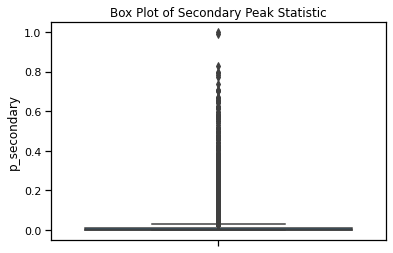

In [44]:
sns.boxplot(y = df_exo_noLC.p_secondary)
plt.title('Box Plot of Secondary Peak Statistic')
plt.show()

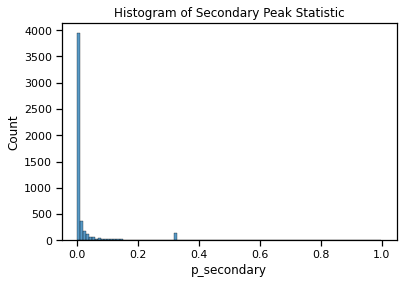

In [45]:
sns.histplot(df_exo_noLC.p_secondary, bins = 100)
plt.title('Histogram of Secondary Peak Statistic')
plt.show()

This is no good...but in retrospect somewhat expected given the exponential nature of this feature. Almost all the features are bunched heavily at very small values of p_secondary close to 0 compared to the full scale 0 to 1. A quick view of some of the actual values show that it would be good to log transform this feature.

In [46]:
df_exo_noLC.p_secondary.head(15)

KIC_ID   TCE_num
757450   1          7.862001e-03
1026032  1          0.000000e+00
1293031  1          2.892565e-01
1432214  1          4.340181e-06
1432789  1          8.181007e-03
1433962  1          2.524845e-01
1433980  1          4.525216e-04
1571511  1          1.458687e-34
1575690  1          6.367605e-02
1718189  1          1.733169e-04
         2          4.079879e-04
1722276  1          2.118383e-06
1724719  1          2.860872e-03
1725016  1          3.933380e-04
1725193  1          2.149962e-01
Name: p_secondary, dtype: float64

In [47]:
(df_exo_noLC.p_secondary == 0).sum() # ok there are a bunch of zeros so before visualizing the log transformation, we'll just get rid of these for now. will have to deal with these zeroes later.

552

In [48]:
psecnozeroes = df_exo_noLC[~(df_exo_noLC.p_secondary == 0)].p_secondary  # series of p_secondary with zeroes dropped
abs_log_psec = np.abs(np.log10(psecnozeroes)) # we take abs value as 0 < p_secondary < 1 ==> log psec < 0

<AxesSubplot:ylabel='p_secondary'>

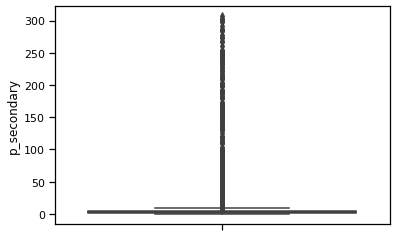

In [49]:
sns.boxplot(y = abs_log_psec)

Still not great...what about square rooting the log? The motivation for this comes from the fact that p_secondary is related to erfc(x) -- the complimentary error function.

<AxesSubplot:ylabel='p_secondary'>

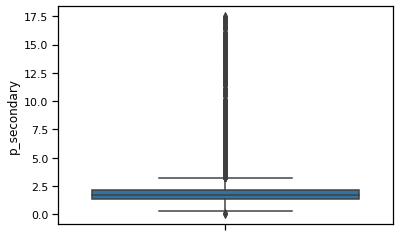

In [50]:
deriv_psec = np.sqrt(abs_log_psec)
sns.boxplot(y = deriv_psec)

OK that actually looks better. Let's take a look at the count histogram of the sqrt log.

<AxesSubplot:xlabel='p_secondary', ylabel='Count'>

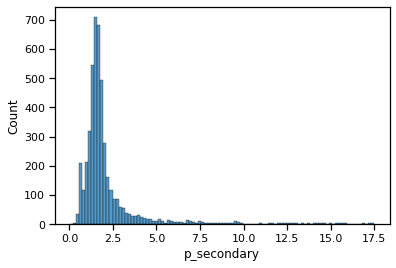

In [51]:
sns.histplot(deriv_psec, bins = 100)

OK this actually looks like the values are on a reasonable scale so that we can distinguish between different portions of the distribution in a smooth way. We'll thus use the sqrt of the absolute value of the log of p_secondary for visualization and for using in our modeling. This transformation also makes sense given that p_secondary is drawn from tail integrals of a Gaussian.

In [52]:
new_df = df_exo_noLC.loc[deriv_psec.index, ['target_label', 'p_secondary']]
new_df['deriv_psec'] = np.sqrt(np.abs(np.log10(new_df.p_secondary)))

<AxesSubplot:xlabel='deriv_psec', ylabel='Count'>

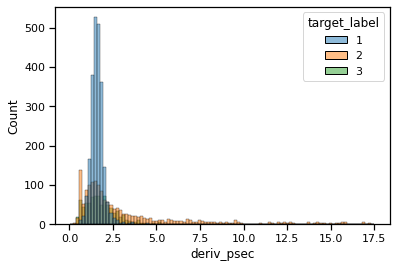

In [53]:
sns.histplot(x = 'deriv_psec',data = new_df, hue = 'target_label', bins = 100)

The tail of the distribution is almost completely dominated by class 2 (which is the secondary eclipse class). Meanwhile the confirmed planets are distributed compactly around 1.25 in what looks like a normal distribution. In fact, the majority of TCEs with deriv_psec > 2.5 are False positives (either class 2 or 3). That's a good sign that this derived feature will be useful in separating out secondary eclipses from confirmed planets. 

There are also ~ 550 KICs for which p_secondary is zero. We'll treat these by mapping these to the max value of deriv_psec (as these will be the most extreme values in the distribution.)

In [54]:
(df_exo_noLC['p_secondary'] == 0).sum()

552

OK let's deal with the zeros in p_secondary. We'll do this more systematically during model preprocessing

In [55]:
abs_log = np.abs(np.log10(df_exo_noLC['p_secondary'])) # there will be np.inf where p_secondary will be zero
maxlogsec = abs_log[~(abs_log == np.inf)].max() # gets max of abs log p_secondary with np.infs cut out.

# replace np.inf with max

abs_log_no_inf = abs_log.replace(np.inf, maxlogsec) # this should work
sqrtabslog = np.sqrt(abs_log_no_inf)
df_exo_noLC['sqrtabslog_psec'] = sqrtabslog

C:\Users\prave\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='sqrtabslog_psec', ylabel='Count'>

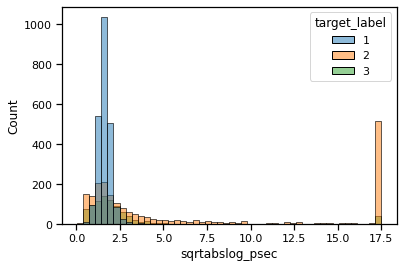

In [56]:
sns.histplot(x = 'sqrtabslog_psec', data = df_exo_noLC, hue = 'target_label', bins = 50)

OK this is definitely a hack, but it should work well enough for what we are trying to do. 

(Note for future: I wanted to deal with integrals of the probability but perhaps it would work better to use the t-statistic itself as the extracted feature as the observations are already on a standardized linear scale. In any case, let's stick with what we are doing for now.)


There are definitely some members of class 3 that pass the secondary peak test (corresponding to cases that we mentioned in the first EDA notebook) but again it's clear to see that for all values of sqrt absolute value of the log of p_secondary > 2.5 is dominated by false positives and > 3 is dominated by class 2.

Let's finish this up with a count breakdown by class and regime ( sqrtabslog_psec > 2.5, sqrtabslog_psec < 2.5):

In [57]:
df_exo_noLC['psec_condit'] = (df_exo_noLC.sqrtabslog_psec >= 2.5).astype('int').replace({0: '< 2.5', 1: '> 2.5' })

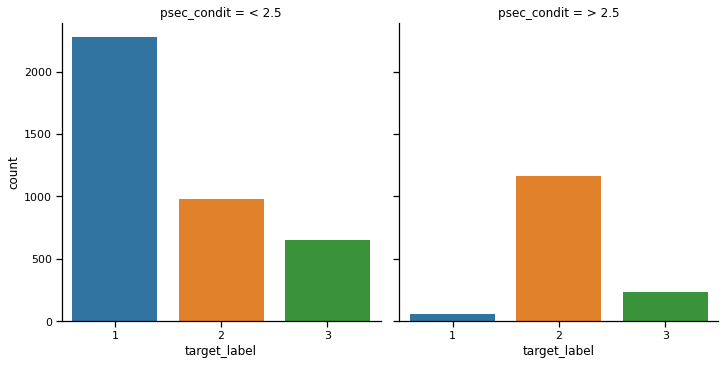

In [58]:
sns.catplot(x = 'target_label', data = df_exo_noLC, col = 'psec_condit', kind = 'count')

This clarifies the idea that for psec_condit > 4, the observations are dominated by false positives (particularly class 2). The condition just on sqrtabslog_psec accounts for more than half of the class 2 false positives while providing class separation from 1.

In [59]:
df_exo_noLC[['target_label', 'sqrtabslog_psec' ]].loc[df_exo_noLC.sqrtabslog_psec > 2.5, 'target_label'].value_counts()

2    1164
3     232
1      57
Name: target_label, dtype: int64

### Visualizing even_odd_stat

It's pretty clear that most of the observations with even_odd_stat close to 0 are in class 2. Again, as the feature is a p-value, this is a good sign and means the feature is doing a good job.

<AxesSubplot:xlabel='even_odd_stat', ylabel='Count'>

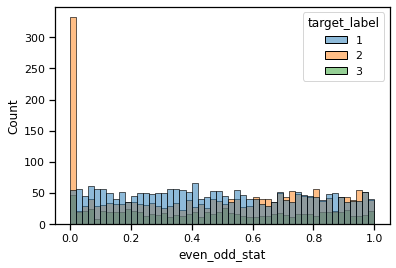

In [60]:
sns.histplot(x = 'even_odd_stat', data = df_exo_noLC, hue = 'target_label', bins = 50)

We are going to run into a similar issue as p_secondary: it would be best to take the square root of the absolute value of the log of the even_odd_stat putting the p-value roughly speaking on a linear scale. We'll again need to treat cases of the even_odd_stat being 0 separately. This skews the statistics somewhat but again should be fine. We will do it in pretty much the same way we did for p_secondary.

In [61]:
abs_logevenodd = np.abs(np.log10(df_exo_noLC['even_odd_stat'])) # there will be np.inf where p_secondary will be zero
maxlogevenoddstat = abs_logevenodd[~(abs_logevenodd == np.inf)].max() # gets max of abs log p_secondary with np.infs cut out.

# replace np.inf with max

abs_logevenodd_no_inf = abs_logevenodd.replace(np.inf, maxlogsec) # this should work
sqrtabslogevenodd = np.sqrt(abs_logevenodd_no_inf)
df_exo_noLC['sqrtabslog_evenodd'] = sqrtabslogevenodd

C:\Users\prave\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='sqrtabslog_evenodd', ylabel='Count'>

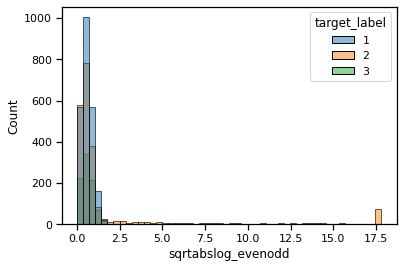

In [62]:
sns.histplot(x = 'sqrtabslog_evenodd', data = df_exo_noLC, hue = 'target_label', bins = 50)

This shows that from 0-2 of this new_feat (sqrt abs_val of log of the p-value), the three classes have similar count distributions. However, for new_feat > 2, almost all the examples are in class 2 (a secondary eclipse false positive). Mapping back to p-values on our even-odd peak amplitude ttest, this implies that the secondary eclipse false positives dominate for even_odd_stat p-vals < 1e-4.

A simple visualization should suffice:

In [63]:
df_exo_noLC['evenodd_condit'] = (df_exo_noLC.sqrtabslog_evenodd >= 2).astype('int').replace({0: '< 2', 1: '> 2' })

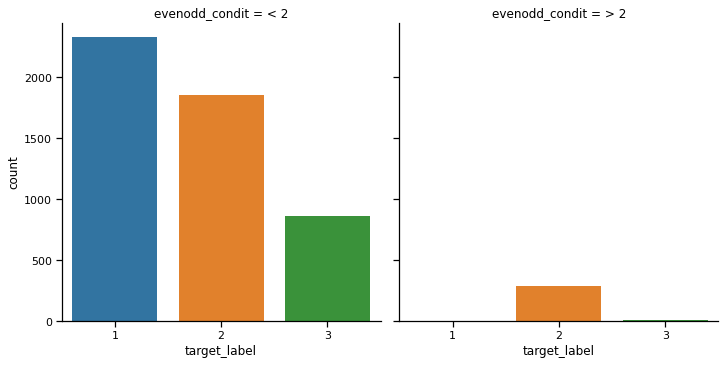

In [64]:
sns.catplot(x = 'target_label', data = df_exo_noLC, col = 'evenodd_condit', kind = 'count')

the region where even_odd_stat or p_secondary (or the respective derived features) are dominated by class 2 are largely non-intersecting: which is a good thing. These two features capture different sectors of the secondary eclipse false positives while providing decent class distinction between secondary eclipse false positives and the other two classes.

In [65]:
# secondary peak statistic in class 2 dominant region
df_exo_noLC[['target_label', 'sqrtabslog_psec' ]].loc[df_exo_noLC.sqrtabslog_psec > 2.5, 'target_label'].value_counts() 

2    1164
3     232
1      57
Name: target_label, dtype: int64

In [66]:
# odd-even statistic in class 2 dominant region
df_exo_noLC[['target_label', 'sqrtabslog_psec' ]].loc[df_exo_noLC.sqrtabslog_evenodd > 2, 'target_label'].value_counts()

2    286
3     14
1      3
Name: target_label, dtype: int64

In [67]:
# the intersection between the two in class 2 dominant region
((df_exo_noLC['evenodd_condit'] == '> 2') & (df_exo_noLC['psec_condit'] == '> 2.5')).sum() 

18

In [68]:
# these two features account for a significant fraction of class 2:
tot_class2_num = (df_exo_noLC.target_label == 2).sum()
tot_class2_num

# ~1450/2140 ~ 2/3 of the class 2 lie in this (p_secondary, even_odd_stat) region. Pretty good. 

2140

## Other non-LCBIN features (Period, Depth, Duration, time_complexity, rms, max, min):

First thing's first, let's look at the feature correlation to see if we have column redundacies in the extracted features:

<AxesSubplot:>

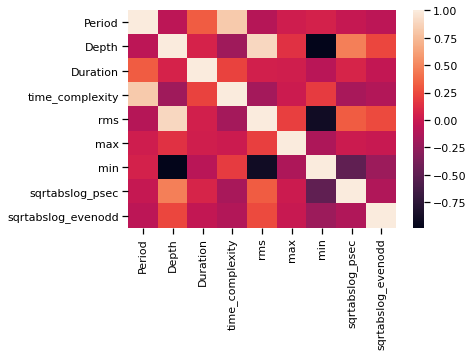

In [32]:
cols_to_keep = ['Period', 'Depth', 'Duration', 'time_complexity', 'rms', 'max', 'min', 'sqrtabslog_psec', 'sqrtabslog_evenodd']
sns.heatmap(df_exo_noLC[cols_to_keep].corr())

In [33]:
df_exo_noLC[cols_to_keep].corr()

Period     Depth  Duration  time_complexity       rms  \
Period              1.000000 -0.067259  0.321121         0.822030 -0.099161   
Depth              -0.067259  1.000000  0.067247        -0.193377  0.895912   
Duration            0.321121  0.067247  1.000000         0.219258  0.045528   
time_complexity     0.822030 -0.193377  0.219258         1.000000 -0.169880   
rms                -0.099161  0.895912  0.045528        -0.169880  1.000000   
max                 0.028587  0.143046  0.035139         0.009795  0.208280   
min                 0.060193 -0.982245 -0.076655         0.188583 -0.896933   
sqrtabslog_psec    -0.015607  0.469874  0.072975        -0.154451  0.322652   
sqrtabslog_evenodd -0.067025  0.234088 -0.034536        -0.108088  0.249342   

                         max       min  sqrtabslog_psec  sqrtabslog_evenodd  
Period              0.028587  0.060193        -0.015607           -0.067025  
Depth               0.143046 -0.982245         0.469874            0.234088  
Duration            0.035139 -0.076655         0.072975           -0.034536  
time_complexity     0.009795  0.188583        -0.154451           -0.108088  
rms                 0.208280 -0.896933         0.322652            0.249342  
max                 1.000000 -0.132467         0.015787           -0.007981  
min                -0.132467  1.000000        -0.492301           -0.214329  
sqrtabslog_psec     0.015787 -0.492301         1.000000           -0.118255  
sqrtabslog_evenodd -0.007981 -0.214329        -0.118255            1.000000

There is a pretty high correlation of -0.98 between the Kepler cumulative table extracted Depth and min (extracted from the time-series) as might be expected. The same goes with rms and min. Let's keep min as this is extracted without reference to a specific transit model...which I like. Drop rms and Depth for modeling.

The period and time_complexity also have a really high positive correlation (+ 0.82). The time_complexity feature implemented by tsfresh's cid_ce feature calculator doesn't have a clear physical meaning whereas the period is a natural feature. Drop time_complexity for modeling.

Finally, there seems to be a non-negligible Pearson correlation between min and sqrtabslog_psec. Let's take a look:

<AxesSubplot:xlabel='min', ylabel='sqrtabslog_psec'>

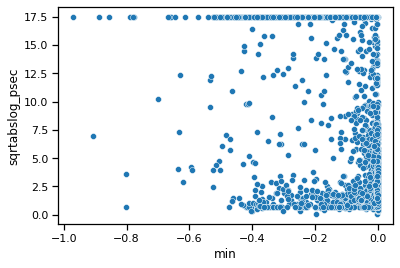

In [34]:
sns.scatterplot(x = 'min', y = 'sqrtabslog_psec', data = df_exo_noLC)

Hmmm...there doesnt't seem to be any interacions between these two that I might have to worry about, so let's proceed.

In [35]:
df_subset = df_exo_noLC[['Period','Duration', 'Depth', 'max', 'min', 'target_label']]
df_subset.head()

Period  Duration    Depth       max       min  \
KIC_ID  TCE_num                                                      
757450  1          8.884923   2.07004  16053.4  0.000177 -0.015739   
1026032 1          8.460439   4.73492  76412.9  0.000360 -0.077604   
1293031 1          0.539366   5.43400    145.0  0.000026 -0.000017   
1432214 1        161.788327   5.31000  87750.0  0.001184 -0.086902   
1432789 1          9.931463   5.67800    398.6  0.000360 -0.000422   

                target_label  
KIC_ID  TCE_num               
757450  1                  1  
1026032 1                  2  
1293031 1                  3  
1432214 1                  2  
1432789 1                  1

I think the ecdf provides a nice visualization of class separation for the 'min' feature. Most of the instances of class 1 are bunched at lower depths of <= 0.02 while the false positives have a much longer tail into lower values for min. There's significant overlap between classes 2 and 3 with this feature.

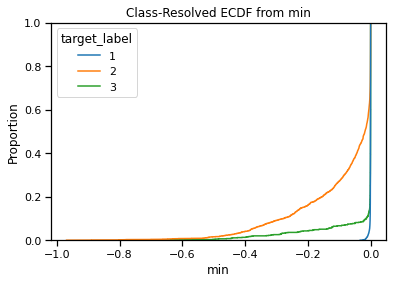

In [36]:
sns.ecdfplot(x = 'min', hue = 'target_label', data = df_subset)
plt.title('Class-Resolved ECDF from min')
plt.show()

A close-up will help in this:

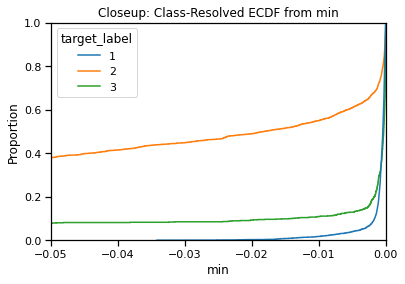

In [37]:
sns.ecdfplot(x = 'min', hue = 'target_label', data = df_subset)
plt.title('Closeup: Class-Resolved ECDF from min')
plt.xlim(-.05,0)
plt.show()


(0.0, 0.04)

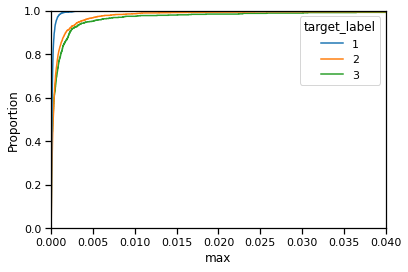

In [38]:
sns.ecdfplot(x = 'max', hue = 'target_label', data = df_subset)
plt.xlim(0,.04)

The observations with max above 0.025 - 0.02 are dominated by the false positive classes. However, the class separation between the two false positive classes 2 and 3 is not high. Finally let's take a look at the Duration:

<AxesSubplot:xlabel='Duration', ylabel='Count'>

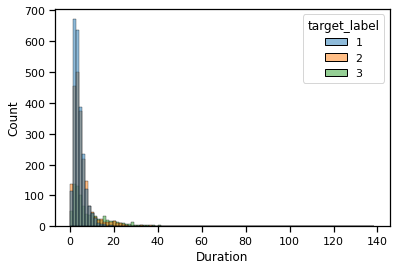

In [39]:
sns.histplot(x = 'Duration', bins = 100, hue = 'target_label', data = df_subset)

In terms of transit duration from the KOI cumulative, the bulk of the distributions for each class are right on top of each other. Yet again, the tails are dominated by FPs. Let's take a closer look with the ecdf.

<AxesSubplot:xlabel='Duration', ylabel='Proportion'>

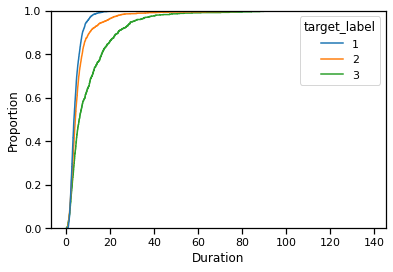

In [40]:
sns.ecdfplot(x = 'Duration', hue = 'target_label', data = df_subset)

It does seem that the class 3 False positive proportonately dominates the tail region of the Duration distribution. Finally, there is the Period:

<AxesSubplot:xlabel='Period', ylabel='Count'>

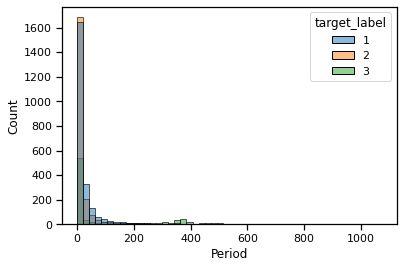

In [41]:
sns.histplot(x = 'Period', hue = 'target_label', bins = 50, data = df_subset)

(0.0, 100.0)

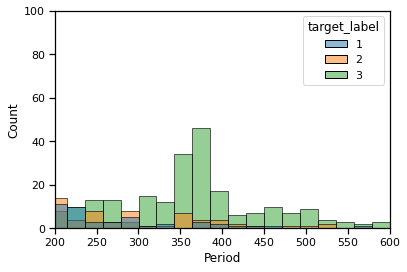

In [42]:
sns.histplot(x = 'Period', hue = 'target_label', bins = 50, data = df_subset)
plt.xlim(200,600)
plt.ylim(0,100)

That's interesting. The long period observations are almost entirely dominated by class 3 false positives. Thus this feature will be helpful in separating out class 2 and class 3 FPs.

In [43]:
df_subset.loc[df_subset.Period > 250, 'target_label'].value_counts()

3    203
2     41
1     21
Name: target_label, dtype: int64

## EDA on LCBIN features

In [44]:
df_exo_lc = df_exo.loc[:,'LCBIN_0':'LCBIN_140']
df_exo_lc.head()

LCBIN_0   LCBIN_1   LCBIN_2   LCBIN_3   LCBIN_4   LCBIN_5  \
KIC_ID  TCE_num                                                               
757450  1       -0.003788 -0.002984 -0.002181 -0.001378 -0.000574  0.000229   
1026032 1        0.001511  0.001346  0.001181  0.001016  0.000769  0.000522   
1293031 1       -1.000000 -0.979731 -0.959462 -0.939192 -0.918923 -0.898654   
1432214 1       -0.001213 -0.000347  0.000518  0.001384 -0.000081 -0.001546   
1432789 1       -0.134897  0.022390  0.179677  0.148804  0.117931  0.087058   

                  LCBIN_6   LCBIN_7   LCBIN_8   LCBIN_9  ...  LCBIN_131  \
KIC_ID  TCE_num                                          ...              
757450  1        0.001032  0.001835  0.002639  0.002161  ...   0.003811   
1026032 1        0.000275  0.000028  0.000431  0.000833  ...   0.001283   
1293031 1       -0.878385 -0.858115 -0.837846 -0.817577  ...   0.417232   
1432214 1       -0.003011 -0.001262  0.000488  0.002237  ...  -0.000726   
1432789 1        0.087296  0.087535  0.087774  0.038117  ...   0.182302   

                 LCBIN_132  LCBIN_133  LCBIN_134  LCBIN_135  LCBIN_136  \
KIC_ID  TCE_num                                                          
757450  1         0.003485   0.004310   0.005135   0.005959   0.006784   
1026032 1         0.001274   0.001265   0.001134   0.001003   0.000872   
1293031 1         0.435126   0.453019   0.470913   0.488807   0.506700   
1432214 1        -0.000781  -0.000837  -0.000892  -0.000278   0.000336   
1432789 1         0.196967   0.202510   0.208052   0.213595   0.153873   

                 LCBIN_137  LCBIN_138  LCBIN_139  LCBIN_140  
KIC_ID  TCE_num                                              
757450  1         0.007609   0.008434   0.009258   0.010083  
1026032 1         0.000741   0.000870   0.000999   0.001129  
1293031 1         0.524594   0.542487   0.560381   0.578274  
1432214 1         0.000950   0.001251   0.001553   0.001854  
1432789 1         0.094150   0.034427   0.109613   0.184799  

[5 rows x 141 columns]

In [45]:
from sklearn.manifold import TSNE

In [46]:
TSNE_model = TSNE(learning_rate = 50)
transformed = TSNE_model.fit_transform(df_exo_lc)

In [47]:
tsne_df = pd.DataFrame(transformed, columns = ['TSNE_1', 'TSNE_2'])
tsne_df['class'] = df_exo_noLC['target_label'].to_numpy()
tsne_df['class'] = tsne_df['class'].astype('category')

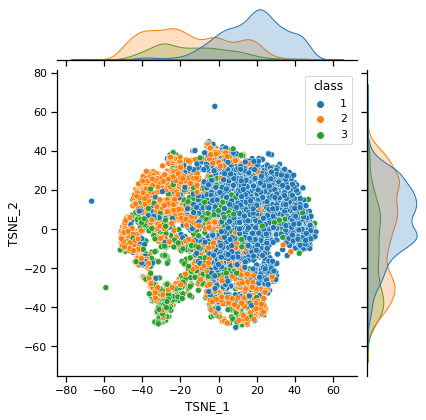

In [48]:
sns.jointplot(x = 'TSNE_1', y = 'TSNE_2', hue='class', data = tsne_df)

TSNE definitely shows that there are different sectors dominated by class 1 (confirmed planets) and the false positives (orange and green). The confirmed planets are heavily concentrated into a more or less continuous block.

There is definitely some grouping in the false positive classes but its not sectored into single contiguous blocks for each FP class. There are definitely a few areas where secondary false positives are dominant in the false positive sectors and areas where non-transiting false positives are more dominant.

It makes sense to use a dimensional reduction technique that can optimally preserve local neighborhood information. It's plausible to argue from TSNE that a collapse of the 141 LC bins to a low dim representation will yield a good feature set provided that we can preserve local neighborhood info.

#### LPP (Locality Preserving Projections) might work here. There's a Python implentation closely following sklearn's structure/syntax provided by Jake van der Plas. Download at https://pypi.org/project/lpproj/

In [73]:
from lpproj import LocalityPreservingProjection 
lpp = LocalityPreservingProjection(n_components=2) 

LC_2D = lpp.fit_transform(df_exo_lc)

In [74]:
LC_LPPreduced = pd.DataFrame(LC_2D, columns = ['LPP_1', 'LPP_2'])
LC_LPPreduced['class'] = df_exo_noLC['target_label'].to_numpy()
LC_LPPreduced['class'] = LC_LPPreduced['class'].astype('category')

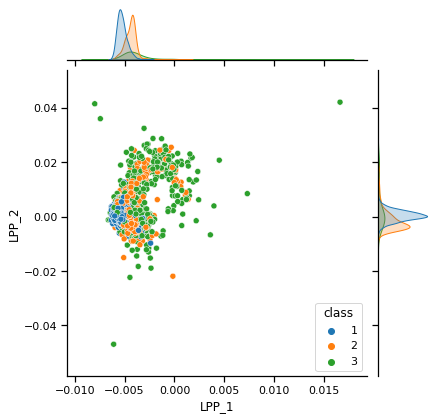

In [102]:
sns.jointplot(x = 'LPP_1', y = 'LPP_2', hue = 'class', data = LC_LPPreduced)

LPP clearly keeps the confirmed planets and FPs bunched among themselves (that means that the algorithm is preserving local neighborhoods). Class 1 (the confirmed planet class) has a distribution that is reasonably distinct (with some overlap) from the false positives.

Lets create a facetgrid with hexbin plots conditoned on class to take a more faithful visual comparison of the distributions in (LPP_1, LPP_2) space 

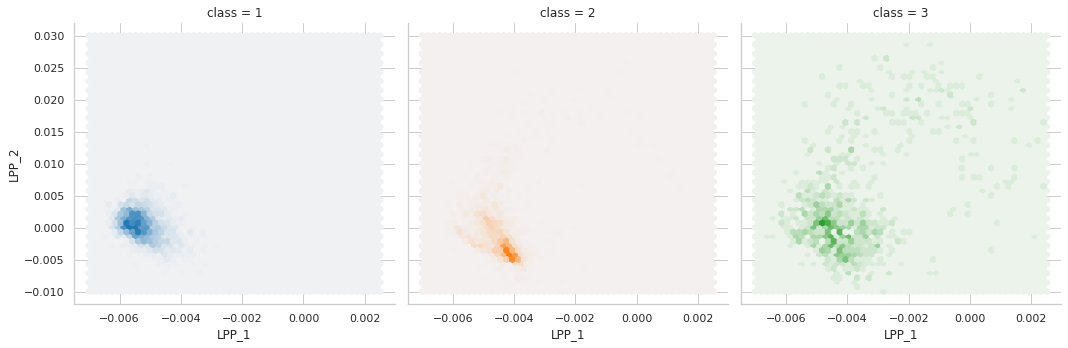

In [116]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=50, cmap=cmap, **kwargs)

with sns.axes_style("whitegrid"):
    g = sns.FacetGrid( LC_LPPreduced, hue="class", col="class", height=5)
g.map(hexbin, "LPP_1", "LPP_2", extent=[-.007, .0025, -.01, .03])

Nice. We can see that while there is certainly overlap class the bulk of the confirmed planet class distribution lies in a region with more negative LPP_1 values and higher LPP_2 (clustered strongly around [-.0058, 0] ) than the FP classes.  The secondary eclipse class class is heavily centered at ~[-.004, -.005]. 

The non-transit class (class 3) does have significant overlap (particularly with class 2) but there are parts of the class 3 distribution that lie outside the bulk of the bulk of the distributions for the other two classes. This is a good thing as we wanted a way of having a feature that made NTPs easier to distinguish from the other class.

Looking at the scatter plot and referencing it with the hexbin we can see that there is a spiral arm off the main central blob of points which is largely dominated by class 3. 

#### To finish up our EDA, n_components = 2 on the LPP dim reduction might be OK. These two along with min, max, Period, Duration, and the two transformed secondary eclipse statistics could be good features to classify on. As a final note, the dimensionality of our LPP reduction is a parameter that we might want to tune. Let's proceed to final preprocessing for model training.